### Fitting Models for early readmission vs non-early readmission Dataset

In [1]:
# Try for 'readmitted_30p' first using the 'diabetes_3d_p30.csv' dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [81]:
# Importing the relevant classes
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Load the required files
X_train_30 = pd.read_csv('./X_train_30.csv')
X_test_30 = pd.read_csv('./X_test_30.csv')
y_train_30 = pd.read_csv('./y_train_30.csv')
y_test_30 = pd.read_csv('./y_test_30.csv')
X_ros_30 = pd.read_csv('./X_ros_30.csv')
y_ros_30 = pd.read_csv('./y_ros_30.csv')

In [5]:
# Drop the 'Unnamed: 0' column
X_train_30.drop('Unnamed: 0', axis=1, inplace=True)
X_test_30.drop('Unnamed: 0', axis=1, inplace=True)
y_train_30.drop('Unnamed: 0', axis=1, inplace=True)
y_test_30.drop('Unnamed: 0', axis=1, inplace=True)
X_ros_30.drop('Unnamed: 0', axis=1, inplace=True)
y_ros_30.drop('Unnamed: 0', axis=1, inplace=True)

This is a binary classification problem and hence different classifiers will be fit to the training set and the classifier that gives the best metrics will be chosen to score the test set and make predictions. The metric that will be used to decide the best classifer will be the precision, recall, f1 and average precision scores. Specifically, a higher average_precision score will indicate a better preformance of the classifier.

In [186]:
# Defining a function to return the precision, recall, f1 and average precision score
# Defining functions to plot Precision-Recall Curve--. 

from sklearn.metrics import precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc

def scores(y_test, y_pred):
    
    '''
    Function takes in y_test, y_predict y_predict probability and scores to return precision, recall, f1 and
    average_precision  scores of the positive class
    '''
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, beta=1.0)
    average_precision = average_precision_score(y_test, y_pred)
    return precision[1], recall[1], f1[1], average_precision

def precision_recall(y_test, y_pred, y_pred_proba, classifier):
    
    '''
    Function accepts the y_test scores and y_predict probability scores to plot the precison-recall curve
    '''
    
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    #plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.step(recall, precision, color='g', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 0.40])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall for ' +classifier+ ' Classifier : AP={0:0.2f}'.format(average_precision))
    return plt

The classifiers used will be Logistic Regression, MLP(Multilayer Perceptron), XGBoost, RandomForest, Naive Bayes and StackingClassifier using Logistic, MLP, XGBoost and RandomForest as base classifiers and Logistic Regression as a Metaclassifier.

The dataset was previously split using stratified splitting into a training set and a test set, with 70% in the training set and 30% in the test set.

GridSearchCV will be used to fit training set with a given classifier and to tune the hyperparameters of the classifiers. Hyperparameter tuning will be optimised based on recall score. The classifier that gives the best recall score will be chosen to predict the test set.

The test set result and prediction accuracy will be checked using confusion matrix, classification report, and the precision-recall curve. A classifier that gives the highest area under the precision-recall curve of the positive class (class 0) will be chosen as the best classifier.

In [104]:
# First fit a Dummy Classifier to get a baseline of prediction on the test set
from sklearn.dummy import DummyClassifier
dm = DummyClassifier(strategy='stratified', random_state=12).fit(X_ros_30,y_ros_30['readmitted_p30'])
y_pred0 = dm.predict(X_test_30)

In [6]:
from sklearn.model_selection import GridSearchCV

In [8]:
# Fitting Logistic Regression
lr_params = {'penalty':['l1','l2'], 'solver':['liblinear'], 'C':list(np.arange(0.1, 5.1, 0.1)), 'random_state':[12]}
lr_gridsearch = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
lr_gridsearch.fit(X_ros_30,y_ros_30['readmitted_p30'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 64.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 76.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.10000000000000001, 0.20000000000000001, 0.30000000000000004, 0.40000000000000002, 0.5, 0.59999999999999998, 0.70000000000000007, 0.80000000000000004, 0.90000000000000002, 1.0, 1.1000000000000001, 1.2000000000000002, 1.3000000000000003, 1.4000000000000001, 1.5000000000000002, 1.60...8, 4.9000000000000004, 5.0], 'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'random_state': [12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [9]:
# The best hyperparamters that maximise recall score
lr_gridsearch.best_params_

{'C': 4.7999999999999998,
 'penalty': 'l1',
 'random_state': 12,
 'solver': 'liblinear'}

In [12]:
# Predicting the test set with the best LogisticRegression Classifier
lr_best = lr_gridsearch.best_estimator_
y_pred1 = lr_best.predict(X_test_30)

In [26]:
# Fitting MLP
mlp_params = {'activation' : ['logistic', 'identity'], 'solver' : ['sgd','lbfgs'], 'learning_rate_init':list(np.arange(0.001, 0.1, 0.01)), 'max_iter':[500], 'random_state':[12]}
mlp_gridsearch = GridSearchCV(MLPClassifier(), mlp_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
mlp_gridsearch.fit(X_ros_30,y_ros_30['readmitted_p30'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 90.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 91.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate_init': [0.001, 0.010999999999999999, 0.020999999999999998, 0.030999999999999996, 0.040999999999999995, 0.05099999999999999, 0.060999999999999992, 0.070999999999999994, 0.080999999999999989, 0.090999999999999984], 'solver': ['sgd', 'lbfgs'], 'max_iter': [500], 'random_state': [12], 'activation': ['logistic', 'identity']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [27]:
# The best hyperparamters that maximise recall score
mlp_gridsearch.best_params_

{'activation': 'logistic',
 'learning_rate_init': 0.001,
 'max_iter': 500,
 'random_state': 12,
 'solver': 'lbfgs'}

In [29]:
best_mlp = mlp_gridsearch.best_estimator_
best_mlp.fit(X_ros_30,y_ros_30['readmitted_p30'])

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=12, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [32]:
# Predicting the test set with the best MLP Classifier
y_pred2 = best_mlp.predict(X_test_30)
print(classification_report(y_test_30['readmitted_p30'], y_pred2))

             precision    recall  f1-score   support

          0       0.92      0.80      0.86      4368
          1       0.12      0.28      0.16       417

avg / total       0.85      0.75      0.80      4785



Even though Gridsearch returned a MLPClassifier with the best hyperparameters that maximise the recall score, the recall score of the positive class is very low. Based on other tuning done, another MLPClassifier with different hyperparamters that increases the recall score of the positive class was fit.

In [33]:
# Fitting another MLPClassifier to increase the recall score of the positive class
mlp2 = MLPClassifier(activation='identity', solver='lbfgs').fit(X_ros_30,y_ros_30['readmitted_p30'])
y_pred2b = mlp2.predict(X_test_30)

In [35]:
print(classification_report(y_test_30['readmitted_p30'], y_pred2b))

             precision    recall  f1-score   support

          0       0.94      0.65      0.77      4368
          1       0.13      0.55      0.21       417

avg / total       0.87      0.65      0.72      4785



In [ ]:
# The recall score of the positive class has increased as compared to the classifier returned by GridSearchCV.

In [105]:
# Fitting XGBoost
xgb_params = {'max_depth':np.arange(3,8,1), 'n_estimators':[1000], 'booster':['gblinear'], 'colsample_bytree':np.arange(0.6,1.05,0.1),'random_state':[12]}
xgb_gridsearch = GridSearchCV(XGBClassifier(), xgb_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
xgb_gridsearch.fit(X_ros_30,y_ros_30['readmitted_p30'])

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7]), 'random_state': [12], 'booster': ['gblinear'], 'colsample_bytree': array([ 0.6,  0.7,  0.8,  0.9,  1. ]), 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [106]:
# The best hyperparamters that maximise recall score
xgb_gridsearch.best_params_

{'booster': 'gblinear',
 'colsample_bytree': 0.59999999999999998,
 'max_depth': 3,
 'n_estimators': 1000,
 'random_state': 12}

In [107]:
# Predicting the test set with the best XGBoost Classifier
best_xgb = xgb_gridsearch.best_estimator_
y_pred3a = best_xgb.predict(X_test_30)

For tree based models such Random ForestClassifier, interaction terms should not be added into the model. The Naive Bayes theorem assumes independence between the features and hence interaction terms should not be added into the model. Hence, a new Dataframe of X variables(features) excluding the interaction terms was created for modeling. The interaction terms were also removed from the test set.

In [37]:
# Getting the list of interaction terms
non_interaction = [i for i in X_train_30.columns if '&' not in i]

In [40]:
# Create new X DataFrames that do not contain the interaction
X_train_30n = X_train_30.loc[:, non_interaction]
X_test_30n = X_test_30.loc[:, non_interaction]
X_ros_30n = X_ros_30.loc[:, non_interaction]

In [63]:
# Fitting RandomForest
rf_params = {'max_depth':np.arange(3,8,1), 'n_estimators':[1000], 'criterion':['entropy','gini'], 'max_features':np.arange(10,16,1),'random_state':[12]}
rf_gridsearch = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, scoring='recall', n_jobs=-1)
rf_gridsearch.fit(X_ros_30n,y_ros_30['readmitted_p30'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 69.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7]), 'random_state': [12], 'max_features': array([10, 11, 12, 13, 14, 15]), 'criterion': ['entropy', 'gini'], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [64]:
# The best hyperparamters that maximise recall score
rf_gridsearch.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 10,
 'n_estimators': 1000,
 'random_state': 12}

In [66]:
# Predicting the test set with the best RandomForest Classifier
rf_best = rf_gridsearch.best_estimator_
y_pred4 = rf_best.predict(X_test_30n)

In [208]:
rf_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

Next, Naive Bayes Classifier was used to fit the training set. GaussianNB Classifier was fit on the continuous features only while MultinomialNB Classifier was fit on the categorical features only. The predicted class probabilities of the test set from these 2 classifiers was obtained and the overall class membership of each patient was calculated based on the average of the 2 class probabilities.

In [69]:
#Defining the numerical and categorical features
num_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',]
cat_features = [i for i in X_ros_30n.columns if i not in num_features]

In [70]:
# Subsetting out the numerical and categorical Dataframes in the training set
X_ros_30num = X_ros_30n.loc[:,num_features]
X_ros_30cat = X_ros_30n.loc[:,cat_features]
X_test_30num = X_test_30n.loc[:,num_features]
X_test_30cat = X_test_30n.loc[:,cat_features]

In [72]:
# Fit the GaussianNB model on numerical features and get predicted probabilities
gb_num = GaussianNB().fit(X_ros_30num, y_ros_30['readmitted_p30'])
gb_proba = gb_num.predict_proba(X_test_30num)

In [77]:
# Fit the MultinomialNB model on categorical features and get predicted probs
mn_cat = MultinomialNB().fit(X_ros_30cat, y_ros_30['readmitted_p30'])
mn_proba = mn_cat.predict_proba(X_test_30cat)

In [79]:
# Get Dataframe on these predicted probabilities from both numerical and categorical features
NB_30 = pd.DataFrame(data = {'num_0':gb_proba[:,0], 'cat_0':mn_proba[:,0], 'num_1':gb_proba[:,1], 'cat_1':mn_proba[:,1]})
NB_30['class_0'] = NB_30[['num_0','cat_0']].sum(axis=1)/2
NB_30['class_1'] = NB_30[['num_1','cat_1']].sum(axis=1)/2

# 'y_label' refers to the overall class membership of the patient based on the average of the predicted probabilities of classifiers fit on just numerical or categorical data
NB_30['y_label'] = NB_30['class_1'].apply(lambda x: 1 if x>0.5 else 0)

A Stacking Classifier was used to fit the training data. A Stacking Classifier uses base estimators(classifiers) to fit the training data and make predictions on the test set. The predictions from each base estimator are then used as new features which are fit into a metaclassifier, and then used to get the final predictions on the test set.

In [110]:
# Fitting a Stacking Classifier
lr = LogisticRegression(C=4.7999999999999998, penalty='l1', random_state=12, solver='liblinear')
mlp = MLPClassifier(activation='identity', solver='lbfgs', random_state=12)
xgb = XGBClassifier(booster='gblinear', colsample_bytree=0.59999999999999998, max_depth=3, n_estimators=1000, random_state=12)
rf = RandomForestClassifier(criterion='gini', max_depth=7, max_features=10, n_estimators=1000, random_state=12)
sclf = StackingClassifier(classifiers=[lr, mlp, xgb, rf], 
                          meta_classifier=LogisticRegression())

In [111]:
sclf.fit(X_ros_30,y_ros_30['readmitted_p30'])

StackingClassifier(average_probas=False,
          classifiers=[LogisticRegression(C=4.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), MLPClassifier(activatio...timators=1000, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [120]:
y_pred6 = sclf.predict(X_test_30)

### Comparing the performance of the different Classifiers

In [ ]:
# Confusion Matrix and Classification Report of each classifier

In [121]:
# Dummy Classifier Confusion Matrix
conmat0 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred0, labels=[1,0]))
confusion0 = pd.DataFrame(conmat0, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion0

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,207,210
not_early_readmit,2142,2226


In [122]:
# Dummy Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred0))

             precision    recall  f1-score   support

          0       0.91      0.51      0.65      4368
          1       0.09      0.50      0.15       417

avg / total       0.84      0.51      0.61      4785



In [123]:
# Logistic Regression Confusion Matrix
conmat1 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred1, labels=[1,0]))
confusion1 = pd.DataFrame(conmat1, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion1

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,227,190
not_early_readmit,1515,2853


In [124]:
# Logistic Regression Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred1))

             precision    recall  f1-score   support

          0       0.94      0.65      0.77      4368
          1       0.13      0.54      0.21       417

avg / total       0.87      0.64      0.72      4785



In [125]:
# MLP Classifier Confusion Matrix
conmat2 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred2b, labels=[1,0]))
confusion2 = pd.DataFrame(conmat2, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion2

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,228,189
not_early_readmit,1509,2859


In [126]:
# MLP Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred2b))

             precision    recall  f1-score   support

          0       0.94      0.65      0.77      4368
          1       0.13      0.55      0.21       417

avg / total       0.87      0.65      0.72      4785



In [127]:
# XGB Classifier Confusion Matrix
conmat3 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred3a, labels=[1,0]))
confusion3 = pd.DataFrame(conmat3, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion3

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,224,193
not_early_readmit,1518,2850


In [128]:
# XGB Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred3a))

             precision    recall  f1-score   support

          0       0.94      0.65      0.77      4368
          1       0.13      0.54      0.21       417

avg / total       0.87      0.64      0.72      4785



In [195]:
# RandomForest Classifier Confusion Matrix
conmat4 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred4, labels=[1,0]))
confusion4 = pd.DataFrame(conmat4, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion4

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,90,327
not_early_readmit,450,3918


In [194]:
# RandomForest Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred4))

             precision    recall  f1-score   support

          0       0.92      0.90      0.91      4368
          1       0.17      0.22      0.19       417

avg / total       0.86      0.84      0.85      4785



In [131]:
# Naive Bayes Classifier Confusion Matrix
conmat5 = np.array(confusion_matrix(y_test_30['readmitted_p30'], NB_30['y_label'], labels=[1,0]))
confusion5 = pd.DataFrame(conmat5, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion5

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,167,250
not_early_readmit,1073,3295


In [132]:
# Naive Bayes Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], NB_30['y_label']))

             precision    recall  f1-score   support

          0       0.93      0.75      0.83      4368
          1       0.13      0.40      0.20       417

avg / total       0.86      0.72      0.78      4785



In [133]:
# Stacking Classifier Confusion Matrix
conmat6 = np.array(confusion_matrix(y_test_30['readmitted_p30'], y_pred6, labels=[1,0]))
confusion6 = pd.DataFrame(conmat6, index=['is_early_readmit', 'not_early_readmit'],
                         columns=['predicted_early_readmit','predicted_not_early_readmit'])
confusion6

,predicted_early_readmit,predicted_not_early_readmit
is_early_readmit,95,322
not_early_readmit,514,3854


In [134]:
# Stacking Classifier Classification Report
print(classification_report(y_test_30['readmitted_p30'], y_pred6))

             precision    recall  f1-score   support

          0       0.92      0.88      0.90      4368
          1       0.16      0.23      0.19       417

avg / total       0.86      0.83      0.84      4785



In [159]:
## Combined table of the precision, recall, f1, average_precision scores of the positive class and auc from the different classifiers

a0, b0, c0, d0 = scores(y_test_30['readmitted_p30'], y_pred0)
a1, b1, c1, d1 = scores(y_test_30['readmitted_p30'], y_pred1)
a2, b2, c2, d2 = scores(y_test_30['readmitted_p30'], y_pred2b)
a3, b3, c3, d3 = scores(y_test_30['readmitted_p30'], y_pred3a)
a4, b4, c4, d4 = scores(y_test_30['readmitted_p30'], y_pred4)
a5, b5, c5, d5 = scores(y_test_30['readmitted_p30'], NB_30['y_label'])
a6, b6, c6, d6 = scores(y_test_30['readmitted_p30'], y_pred6)

In [165]:
precision = [a0, a1, a2, a3, a4, a5, a6]
recall = [b0, b1, b2, b3, b4, b5, b6]
f1 = [c0, c1, c2, c3, c4, c5, c6]
ave_precision = [d0, d1, d2, d3, d4, d5, d6]
classifiers = ['Dummy', 'Logistic_Regression', 'MLP', 'XGBoost', 'RandomForest', 'Naive_Bayes', 'Stacking']

In [166]:
classification_metrics = pd.DataFrame(data={'precision':precision, 'recall':recall, 'f1_score':f1, 'average_precision':ave_precision}, index=classifiers)
classification_metrics

,average_precision,f1_score,precision,recall
Dummy,0.314206,0.149675,0.088123,0.496403
Logistic_Regression,0.357191,0.210283,0.130310,0.544365
MLP,0.358761,0.211699,0.131261,0.546763
XGBoost,0.353046,0.207503,0.128588,0.537170
RandomForest,0.351263,0.205530,0.127210,0.534772
Naive_Bayes,0.293702,0.201569,0.134677,0.400480
Stacking,0.225552,0.185185,0.155993,0.227818


Based on the results above, seems like MLP Classifier gives the best results. Naive Bayes and Stacking perform worse than the Dummy Baseline Classifier

In [180]:
help(precision_recall)

Help on function precision_recall in module __main__:

precision_recall(y_test, y_pred, y_pred_proba)
    Function accepts the y_test scores and y_predict probability scores to plot the precison-recall curve



In [201]:
NB_30

,cat_0,cat_1,num_0,num_1,class_0,class_1,y_label
0,0.341044,0.658956,5.771113e-01,0.422889,0.459077,0.540923,1
1,0.668341,0.331659,2.053229e-03,0.997947,0.335197,0.664803,1
2,0.490340,0.509660,6.574034e-01,0.342597,0.573872,0.426128,0
3,0.533338,0.466662,5.306861e-01,0.469314,0.532012,0.467988,0
4,0.300510,0.699490,5.398000e-01,0.460200,0.420155,0.579845,1
5,0.525798,0.474202,6.317385e-01,0.368261,0.578768,0.421232,0
6,0.182913,0.817087,4.958440e-04,0.999504,0.091704,0.908296,1
7,0.747699,0.252301,8.169072e-01,0.183093,0.782303,0.217697,0
8,0.617106,0.382894,7.705615e-01,0.229439,0.693834,0.306166,0
9,0.522512,0.477488,7.385810e-01,0.261419,0.630546,0.369454,0


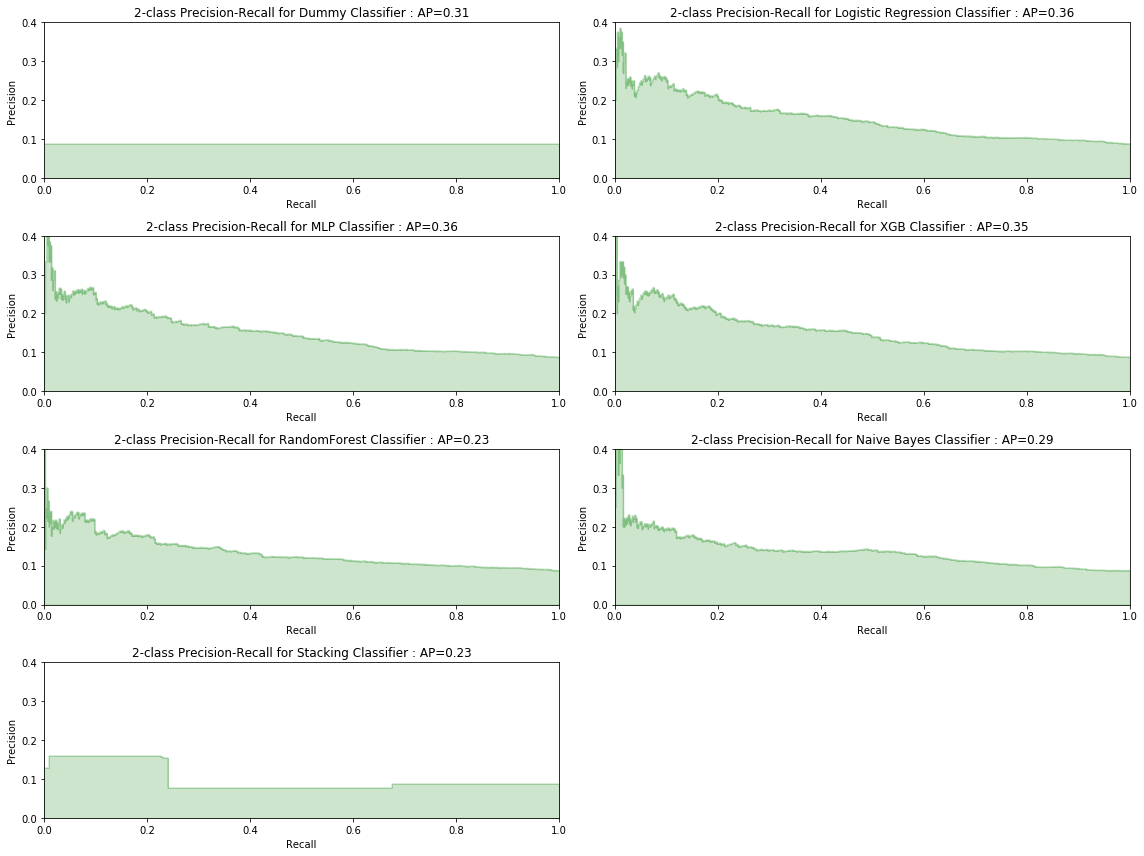

In [210]:
# Plotting the precision-recall curves for the different classifiers

plt.figure(figsize=(16,12))

plt.subplot(4,2,1)
precision_recall(y_test_30['readmitted_p30'], y_pred0, dm.predict_proba(X_test_30)[:,1], 'Dummy')
plt.subplot(4,2,2)
precision_recall(y_test_30['readmitted_p30'], y_pred1, lr_best.predict_proba(X_test_30)[:,1], 'Logistic Regression')
plt.subplot(4,2,3)
precision_recall(y_test_30['readmitted_p30'], y_pred2b, mlp2.predict_proba(X_test_30)[:,1], 'MLP')
plt.subplot(4,2,4)
precision_recall(y_test_30['readmitted_p30'], y_pred3a, best_xgb.predict_proba(X_test_30)[:,1], 'XGB')
plt.subplot(4,2,5)
precision_recall(y_test_30['readmitted_p30'], y_pred4, rf_best.predict_proba(X_test_30n)[:,1], 'RandomForest')
plt.subplot(4,2,6)
precision_recall(y_test_30['readmitted_p30'], NB_30['y_label'], NB_30['class_1'], 'Naive Bayes')
plt.subplot(4,2,7)
precision_recall(y_test_30['readmitted_p30'], y_pred6, sclf.predict_proba(X_test_30)[:,1], 'Stacking')
plt.tight_layout()

Based on the confusion matrix, classification report and the plots above, the best performing classifier on the test set is MLP followed by Logistic Regression. Since MLP Classifier is based on Neural Networks, it is not possible to find the coefficients of the features and hence it is not possible to find out which features contribute the most to the predictions of the readmission outcome. Hence, we will get the coefficients of the features based on the 2nd best model Logistic Regression. However, it should be noted that different models do give different coefficients for the features, and hence that given by the Logistic Regression may not reflect the true importance of features for the MLP Classifer.

In [211]:
# Finding out the coefficients of the features, aka feature importance from Logistic Regression
pd.set_option('display.max_rows', None)
lr_coefs = pd.DataFrame(data={'Features':X_ros_30.columns, 'Coefficients':lr_best.coef_[0], 'Abs_Coefficients':np.abs(lr_best.coef_[0])})
lr_coefs.sort_values(by='Abs_Coefficients', ascending=False)

,Abs_Coefficients,Coefficients,Features
27,4.355579,4.355579,number_inpatient
26,3.172131,3.172131,number_emergency
40,3.033430,3.033430,discharge_disposition_id_3
5,2.744057,-2.744057,chlorpropamide
14,2.444524,-2.444524,tolazamide
37,1.959763,1.959763,admission_type_id_2
35,1.952710,1.952710,age_2
36,1.882875,1.882875,admission_type_id_1
39,1.784033,1.784033,discharge_disposition_id_2
42,1.707546,1.707546,admission_source_id_2


In [212]:
# The top 10 most important features based on Logistic Regression
lr_coefs.sort_values(by='Abs_Coefficients', ascending=False)['Features'][:10]

27              number_inpatient
26              number_emergency
40    discharge_disposition_id_3
5                 chlorpropamide
14                    tolazamide
37           admission_type_id_2
35                         age_2
36           admission_type_id_1
39    discharge_disposition_id_2
42         admission_source_id_2
Name: Features, dtype: object

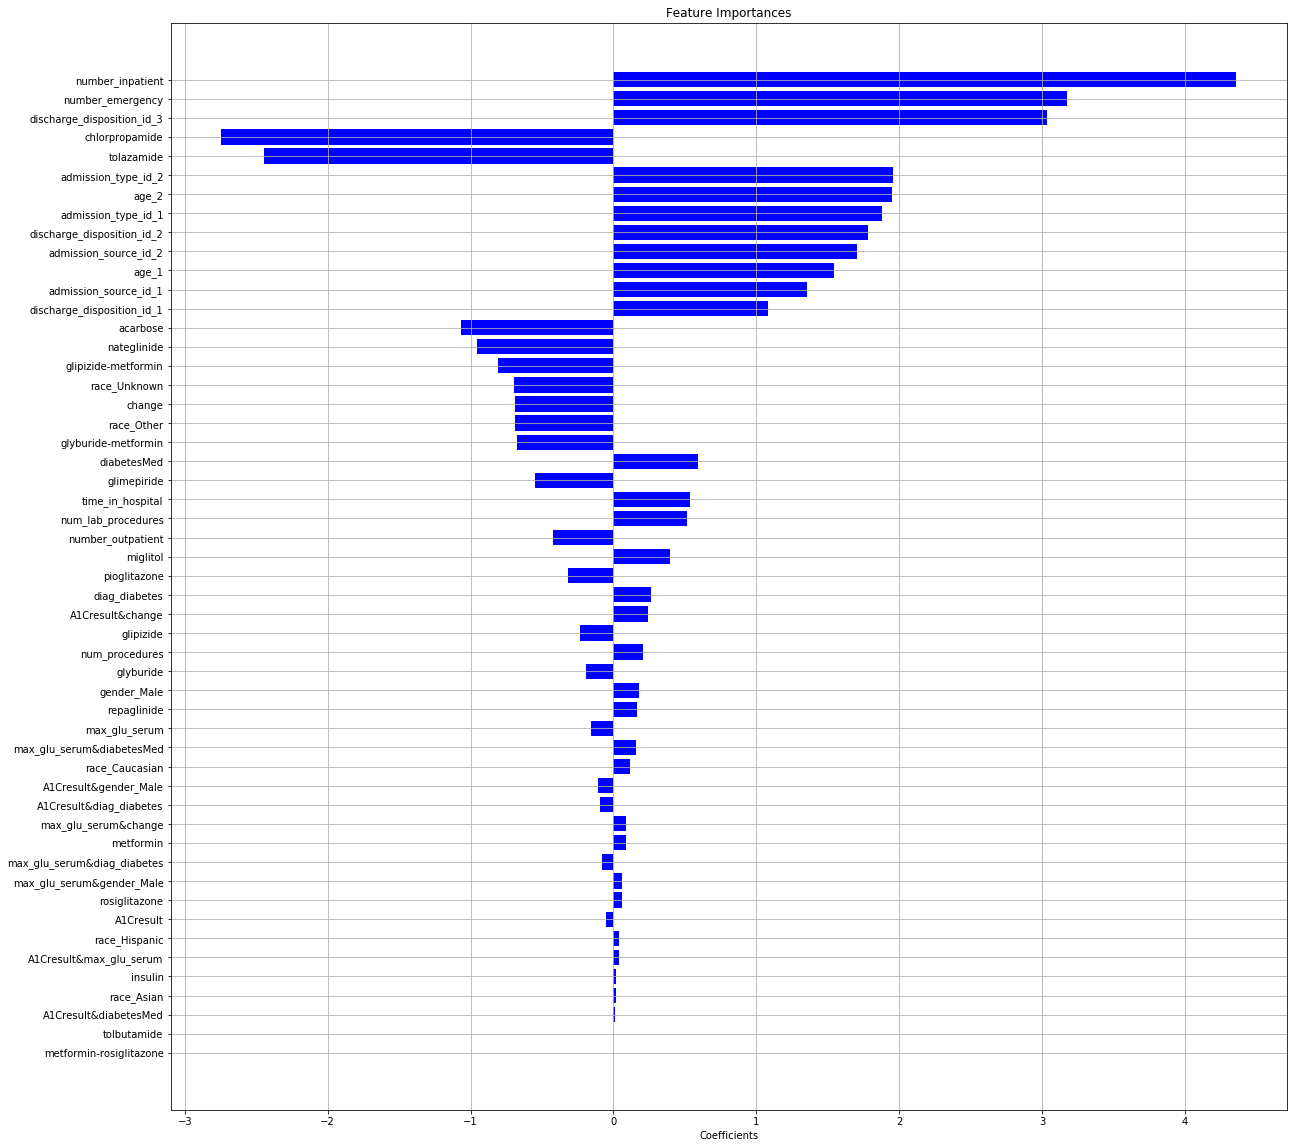

In [215]:
features = lr_coefs.sort_values(by='Abs_Coefficients', ascending=True)['Features']
coefficients = lr_coefs.sort_values(by='Abs_Coefficients', ascending=True)['Coefficients']
indices = np.array(coefficients)

plt.figure(figsize=(20,20))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), coefficients, color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Coefficients')
plt.grid(True)